In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.export import Dim
from ipd import IPD
from network import FCNet
import torch.nn.functional as F

In [3]:
class Agent:
    def __init__(self, network, policy_fn):
        self.network = network
        self.policy_fn = policy_fn

    def act(self, obs):
        value, logits = self.network(obs)
        actions, log_probs = self.policy_fn(logits)
        return actions, value.squeeze(-1), log_probs

In [4]:
def epsilon_softmax_policy(logits, epsilon=0.1):
    batch_size, num_actions = logits.shape
    explore_mask = torch.rand(batch_size) < epsilon

    # Exploitation: softmax sampling
    probs = F.softmax(logits, dim=-1)
    exploit_actions = torch.multinomial(probs, 1).squeeze(-1)

    # Exploration: uniform random actions
    explore_actions = torch.randint(0, num_actions, (batch_size,))

    # Combine exploration and exploitation actions
    actions = torch.where(explore_mask, explore_actions, exploit_actions)

    return actions, F.log_softmax(logits, dim=-1)

In [5]:
def play_episodes(agents, env, num_steps=100):
    batch_data = {
        "obs": ([], []),
        "actions": ([], []),
        "rewards": ([], []),
        "values": ([], []),
        "log_probs": ([], []),
    }

    with torch.no_grad():
        for step in range(num_steps):
            curr_obs = env.obs()

            agent_1_output = agents[0].act(curr_obs[0])
            agent_2_output = agents[1].act(curr_obs[1])

            agent_actions = (agent_1_output[0], agent_2_output[0])
            agent_values = (agent_1_output[1], agent_2_output[1])
            agent_log_probs = (agent_1_output[2], agent_2_output[2])

            _, curr_reward = env.step(agent_actions)

            for agent_idx in range(2):
                batch_data["obs"][agent_idx].append(curr_obs[agent_idx])
                batch_data["actions"][agent_idx].append(agent_actions[agent_idx])
                batch_data["rewards"][agent_idx].append(curr_reward[agent_idx])
                batch_data["values"][agent_idx].append(agent_values[agent_idx])
                batch_data["log_probs"][agent_idx].append(agent_log_probs[agent_idx])

        last_values = (agents[0].act(curr_obs[0])[1], agents[1].act(curr_obs[1])[1])

    for k, v in batch_data.items():
        batch_data[k] = (torch.stack(v[0], dim=0), torch.stack(v[1], dim=0))

    return batch_data, last_values


In [6]:
# Compute general advantaeg alignement
def compute_gae(agent_batch_data, agent_last_values, gae_lambda, gamma):
    advantages = torch.zeros_like(agent_batch_data["rewards"])

    num_steps = len(agent_batch_data["rewards"])
    last_gae = 0
    for t in reversed(range(num_steps)):
        if t == num_steps - 1:
            next_val = agent_last_values
        else:
            next_val = agent_batch_data["values"][t + 1]

        delta = agent_batch_data["rewards"][t] + gamma * next_val - agent_batch_data["values"][t]
        last_gae = delta + gamma * gae_lambda * last_gae
        advantages[t] = last_gae

    returns = advantages + agent_batch_data["values"]

    return advantages, returns


def get_agent_data(batch_data, agent_idx):
    return {k: v[agent_idx] for k, v in batch_data.items()}


def add_avantages_returns(agent_data, agent_last_values, gae_lambda, gamma):
    advantages, returns = compute_gae(agent_data, agent_last_values, gae_lambda, gamma)
    agent_data["advantages"] = advantages
    agent_data["returns"] = returns
    return agent_data


In [7]:
def create_minibatches(agent_data, num_minibatches):
    minibatches = []

    # Get the number of timesteps
    num_steps, batch_size = agent_data["obs"].shape[:2]
    total_samples = num_steps * batch_size

    # Create random indices
    indices = torch.randperm(total_samples)

    # Calculate minibatch size
    minibatch_size = total_samples // num_minibatches

    for i in range(num_minibatches):
        start_idx = i * minibatch_size
        end_idx = (i + 1) * minibatch_size if i < num_minibatches - 1 else total_samples

        minibatch_indices = indices[start_idx:end_idx]

        # Flatten data and select minibatch
        minibatch_data = {}
        for key, value in agent_data.items():
            flat_value = value.view(-1, *value.shape[2:])
            minibatch_data[key] = flat_value[minibatch_indices]

        minibatches.append(minibatch_data)

    return minibatches


In [8]:
def compute_loss(agent_minibatch, network, clip_eps=0.2, value_coeff=0.5, entropy_coeff=0.01):
    values, action_logits = network(agent_minibatch["obs"])
    actions = agent_minibatch["actions"].unsqueeze(-1)

    # Compute log probabilities and entropy
    log_probs = F.log_softmax(action_logits, dim=-1)
    current_log_probs = log_probs.gather(dim=-1, index=actions)
    current_log_probs = current_log_probs.squeeze(-1)
    old_log_probs = agent_minibatch["log_probs"].gather(dim=-1, index=actions)
    old_log_probs = old_log_probs.squeeze(-1)

    # Compute entropy
    probs = F.softmax(action_logits, dim=-1)
    entropy = -torch.sum(probs * log_probs, dim=-1)

    # Normalize advantages
    advantages = agent_minibatch["advantages"]
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Actor loss with clipping
    prob_ratio = torch.exp(current_log_probs - old_log_probs)
    clipped_ratio = prob_ratio.clip(1.0 - clip_eps, 1.0 + clip_eps)
    actor_loss = -torch.minimum(prob_ratio * advantages, clipped_ratio * advantages)

    # Critic loss with clipping
    old_values, returns = agent_minibatch["values"], agent_minibatch["returns"]
    value_pred_clipped = old_values + (values - old_values).clip(-clip_eps, clip_eps)
    value_losses = (values - returns) ** 2
    value_losses_clipped = (value_pred_clipped - returns) ** 2
    critic_loss = 0.5 * torch.maximum(value_losses, value_losses_clipped)

    # Total loss
    total_loss = (
        actor_loss.mean() + value_coeff * critic_loss.mean() - entropy_coeff * entropy.mean()
    )

    info = {
        "actor_loss": actor_loss.mean(),
        "critic_loss": critic_loss.mean(),
        "entropy": entropy.mean(),
        "total_loss": total_loss,
    }
    return total_loss, info




In [9]:
def ppo_train_agent(
    agent_data,
    last_values,
    network,
    optimizer,
    clip_eps=0.2,
    value_coeff=0.5,
    entropy_coeff=0.01,
    gae_lambda=0.95,
    gamma=0.99,
    num_minibatches=16,
):
    agent_data = add_avantages_returns(agent_data, last_values, gae_lambda, gamma)
    data_minibatches = create_minibatches(agent_data, num_minibatches)

    losses, infos = [], []
    for minibatch in data_minibatches:
        optimizer.zero_grad()
        loss, info = compute_loss(minibatch, network, clip_eps, value_coeff, entropy_coeff)
        loss.backward()
        optimizer.step()

        # Tracking
        losses.append(loss)
        infos.append(info)

    return losses, infos


def get_policy(network):
    CC = torch.tensor([1.0, 0.0, 1.0, 0.0])
    DD = torch.tensor([0.0, 1.0, 0.0, 1.0])
    CD = torch.tensor([1.0, 0.0, 0.0, 1.0])
    DC = torch.tensor([0.0, 1.0, 1.0, 0.0])

    obs = torch.stack([CC, DD, CD, DC], dim=0)
    with torch.no_grad():
        _, logits = network(obs)
        probs = F.softmax(logits, dim=-1)

    return probs



In [10]:

env = IPD("cpu", batch_size=4, shared_rewards=True)
networks = [FCNet(4, 2, "cpu", hidden_size=64, num_hidden_layers=2) for _ in range(2)]
optimizers = [torch.optim.Adam(network.parameters(), lr=3e-4) for network in networks]
agents = [
    Agent(networks[0], lambda logits: epsilon_softmax_policy(logits, epsilon=0.1)) for _ in range(2)
]

policies = ([], [])
for _ in range(100):
    batch_data, last_values = play_episodes(agents, env, num_steps=16)
    for agent_idx in range(2):
        ppo_train_agent(
            get_agent_data(batch_data, agent_idx),
            last_values[agent_idx],
            networks[agent_idx],
            optimizers[agent_idx],
        )

        curr_policy = get_policy(networks[agent_idx])
        policies[agent_idx].append(curr_policy)


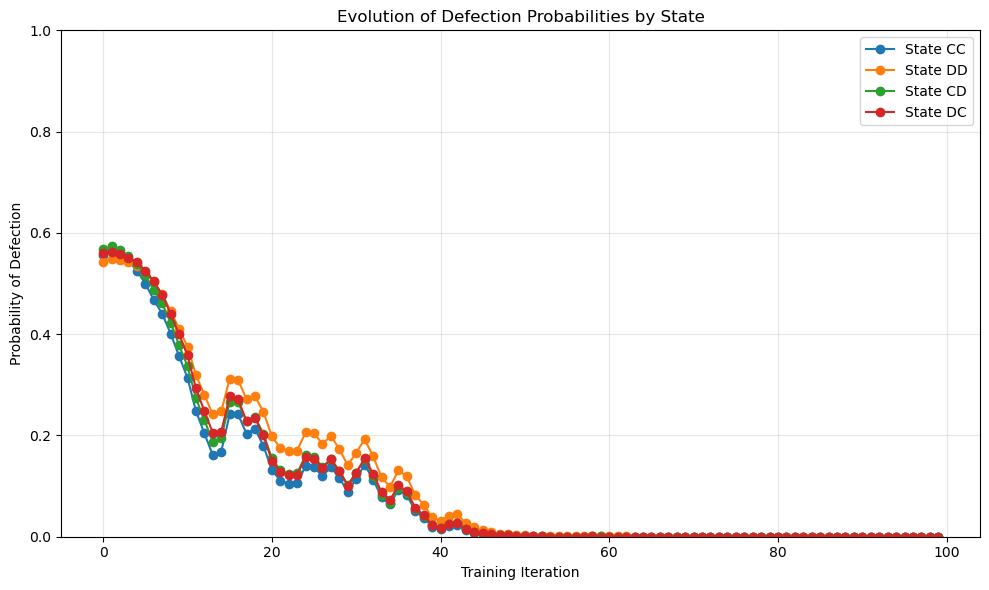

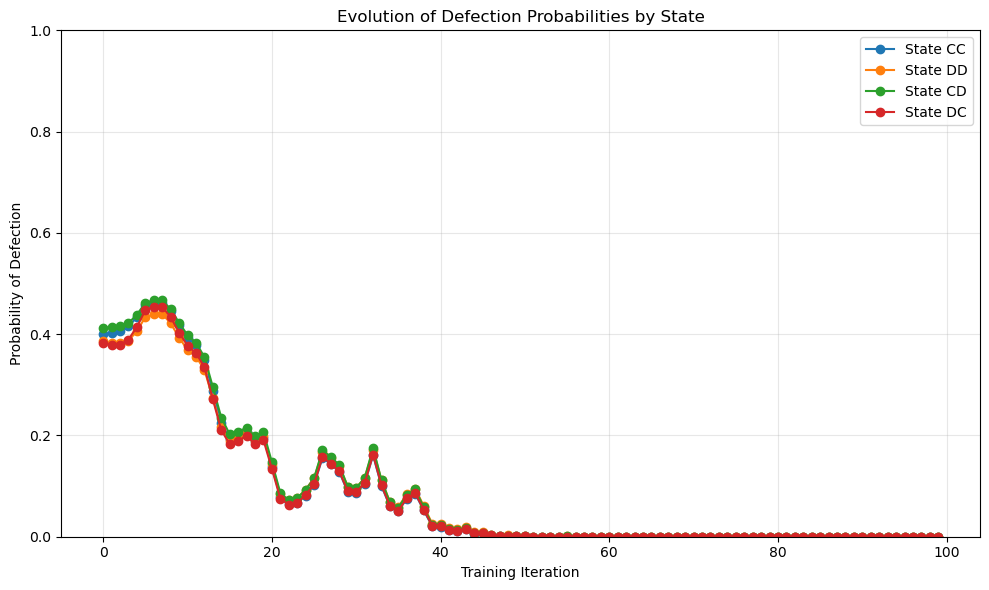

In [11]:
import numpy as np


def plot_defection_probabilities(policy_list):
    state_names = ["CC", "DD", "CD", "DC"]

    # Extract defection probabilities (second column) for each policy
    defection_probs = []
    for policy in policy_list:
        defection_probs.append(policy[:, 1].numpy())  # Second column is defection probability

    # Convert to numpy array for easier plotting
    defection_probs = np.array(defection_probs)

    plt.figure(figsize=(10, 6))

    # Plot each state's defection probability over time
    for state_idx, state_name in enumerate(state_names):
        plt.plot(defection_probs[:, state_idx], label=f"State {state_name}", marker="o")

    plt.xlabel("Training Iteration")
    plt.ylabel("Probability of Defection")
    plt.title("Evolution of Defection Probabilities by State")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


plot_defection_probabilities(policies[0])
plot_defection_probabilities(policies[1])

In [12]:
env = IPD("cpu", batch_size=1)
env.obs()

defect = torch.ones((1), dtype=torch.long)
cooperate = torch.zeros((1), dtype=torch.long)

for a1 in [cooperate, defect]:
    for a2 in [cooperate, defect]:
        print(a1, a2)
        obs, rew = env.step((a1, a2))
        print(obs, rew)

tensor([0]) tensor([0])
(tensor([[1., 0., 1., 0.]]), tensor([[1., 0., 1., 0.]])) (tensor([3.]), tensor([3.]))
tensor([0]) tensor([1])
(tensor([[1., 0., 0., 1.]]), tensor([[0., 1., 1., 0.]])) (tensor([0.]), tensor([5.]))
tensor([1]) tensor([0])
(tensor([[0., 1., 1., 0.]]), tensor([[1., 0., 0., 1.]])) (tensor([5.]), tensor([0.]))
tensor([1]) tensor([1])
(tensor([[0., 1., 0., 1.]]), tensor([[0., 1., 0., 1.]])) (tensor([1.]), tensor([1.]))
